# [ENSO] SiBCASA MSWEP PCR Analysis - Gridded GPP Anomaly

This notebook contains the scripts to read, process and derive the gridded GPP anomaly map 

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
import glob
from mpl_toolkits.basemap import Basemap
#import cartopy.crs as ccrs
import os
from IPython.display import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress

# Directory for input data
os.chdir('/Users/killaars/PhD/Elnino/sibcasa')

%matplotlib inline
sns.set_style('white')

# # Load area in SiBCASA vector format
# import pickle
# area = pickle.load(open('/media/erik/data/cloudstation/asica/data/biosphere_models_ci_ca/gridboxSize.p', 'rb'))

# # Load Amazon mask
# with Dataset('/home/erik/OneDrive/Asica/masks/enso/amazon_mask_1x1.nc') as d:
#     mask = (d['regionmask'][:] == 1)

### Function definitions

- sib_to_2d: Load SiBCASA output file and convert it to a 3d array (time, lat, lon)
- sib_qp3_to_2d: Similar as above, but for qp3 files (NOT USED!)
- globarea: Calculate area in m2 for each gridbox on a grid

In [30]:
# Create function to load variable from SiBCASA onto 2d grid
def sib_to_2d(fname, varname):
    
    with Dataset(fname) as d:
        latindex = d['latindex'][:]
        lonindex = d['lonindex'][:]
        var      = d[varname][:]
    
    print(np.shape(var),np.mean(var))
    values = np.zeros((var.shape[0],180,360))
    values[:,:,:] = 0.

    for i in range(1428):
        lat = latindex[i] - 1
        lon = lonindex[i] - 1
        values[:,lat,lon] = var[:,i]

    return(values)

# Create function to load variable from SiBCASA onto 2d grid
def sib_qp3_to_2d(fname, varname, min_l=0, max_l=14):
    
    with Dataset(fname) as d:
        latindex = d['latindex'][:]
        lonindex = d['lonindex'][:]
        var      = d[varname][:]
        
    var = var[:,min_l:max_l,:].mean(1)
    values = np.zeros((var.shape[0],180,360))
    values[:,:,:] = 0.

    for i in range(1428):
        lat = latindex[i] - 1
        lon = lonindex[i] - 1
        values[:,lat,lon] = var[:,i]
    print(np.shape(values))
    return(values)

# Create 2d field of area per gridbox
def globarea(im=360, jm=180, silent=True):
    '''
    Calculate area per gridbox
    Similar to globarea from TMTools
    '''
    radius = 6.371e6
    deg2rad = np.pi/180.
    dxx=360.0/im*deg2rad
    dyy=180.0/jm*deg2rad
    lat=np.arange(-90*deg2rad,90*deg2rad,dyy)
    dxy=dxx*(np.sin(lat+dyy)-np.sin(lat))*radius**2
    area=np.resize(np.repeat(dxy,im,axis=0) ,[jm,im])
    if not silent:
        print('total area of field = ',sum(area.flat))
        print('total earth area    = ',4*np.pi*radius**2)
    return(area)

# Anomaly map 

(204, 1428) 5.13936448609
(204, 1428) 5.32587044323
(204, 180, 360)


/Users/killaars/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/killaars/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


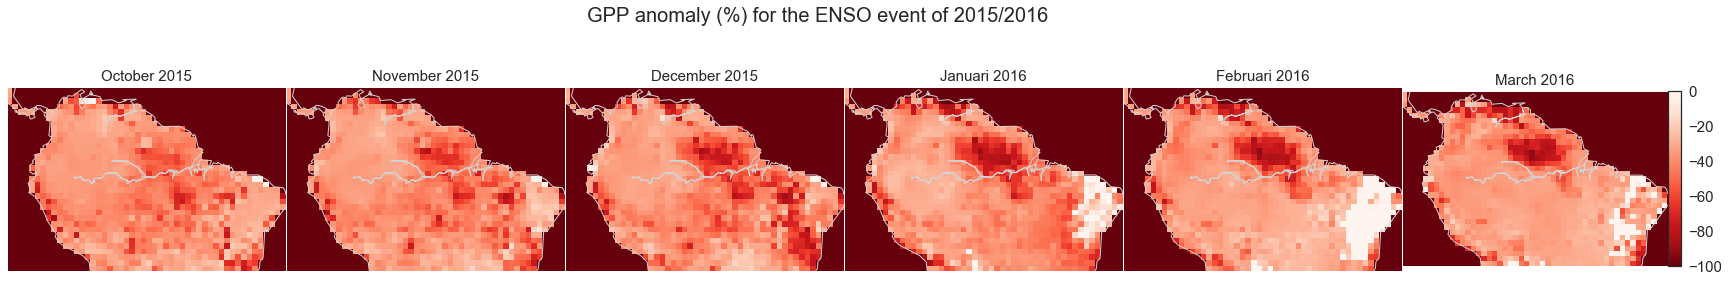

In [54]:
########
# DATA #
########
with Dataset('SiBCASA_ENSO_MSWEP_3m_depth_2000_2016.nc') as d:
    latindex = d['latindex'][:]
    lonindex = d['lonindex'][:]
    lat = d['latitude'][:]
    lon = d['longitude'][:]

# Create 2d fields of monthly means
gpp_2d = sib_to_2d('SiBCASA_ENSO_MSWEP_3m_depth_2000_2016.nc', 'gpp')
gpp_2d_era = sib_to_2d('SiBCASA_ENSO_3m_depth_2000_2016.nc', 'gpp')

print(np.shape(gpp_2d))

# Create climatology (currently based on 2013-2014)
gpp_2d_clim = np.zeros((12,180,360))
for i in range(12):
#     gpp_2d_clim[i] = (gpp_2d[i,:,:] + gpp_2d[i+12,:,:]       #2000,2001
#                    + gpp_2d[i+24,:,:] + gpp_2d[i+36,:,:] #2002,2003
#                    + gpp_2d[i+48,:,:] + gpp_2d[i+60,:,:] #2004,2005
#                    + gpp_2d[i+72,:,:] + gpp_2d[i+84,:,:] #2006,2007
#                    + gpp_2d[i+96,:,:] + gpp_2d[i+108,:,:] #2008,2009
#                    + gpp_2d[i+120,:,:] + gpp_2d[i+132,:,:] #2010,2011
#                    + gpp_2d[i+144,:,:] + gpp_2d[i+156,:,:] #2012,2013
#                    + gpp_2d[i+168,:,:] / 15)               #2014
    gpp_2d_clim[i] = (gpp_2d[i+156,:,:] #2012,2013
                   + gpp_2d[i+168,:,:] / 2)               #2014
# Create anomaly (percentual) for all months
gpp_2d_anom = np.zeros(gpp_2d.shape)
for i in range(gpp_2d.shape[0]):
    iclim = i%12
    gpp_2d_anom[i,:,:] = (gpp_2d[i,:,:] / gpp_2d_clim[iclim,:,:] - 1.) * 100.
    
# Select months
data = gpp_2d_anom[189:195,:,:]


########
# PLOT #
########

# Create meshgrid for plots    
lon, lat = np.meshgrid(lon, lat)
#lat=np.flipud(lat)
# Set clim once for all 6 plots. 
clim=-100., 0.
# -- Create figure
fig = plt.figure(figsize=[30,5])
fig.suptitle('GPP anomaly (%) for the ENSO event of 2015/2016',fontsize='20')#, y=0.65) #y to fix the y-position, otherwise title would float.
gs = GridSpec(1,6,width_ratios=[1,1,1,1,1,1],height_ratios=[1])
gs.update(wspace=0,hspace=0.25)

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("October 2015",fontsize='15')
# m = Basemap(projection='stere',lon_0=-60,lat_0=-15.,lat_ts=50,\
#             llcrnrlat=-20,urcrnrlat=13,\
#             llcrnrlon=-85,urcrnrlon=-35,\
#             rsphere=6371200.,resolution='c',area_thresh=10000)
m = Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,\
            llcrnrlon=-85,urcrnrlon=-35,resolution='c')
m.pcolormesh(lon, lat, data[0,:,:],
             latlon=True, cmap='Reds_r')
m.drawcoastlines(color='lightgray')
m.drawmapboundary(color='white',fill_color='white')
plt.clim(clim)

ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("November 2015",fontsize='15')
# m = Basemap(projection='stere',lon_0=-60,lat_0=-15.,lat_ts=50,\
#             llcrnrlat=-20,urcrnrlat=13,\
#             llcrnrlon=-85,urcrnrlon=-35,\
#             rsphere=6371200.,resolution='c',area_thresh=10000)
m = Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,\
            llcrnrlon=-85,urcrnrlon=-35,resolution='c')
m.pcolormesh(lon, lat, data[1,:,:],
             latlon=True, cmap='Reds_r')
m.drawcoastlines(color='lightgray')
m.drawmapboundary(color='white',fill_color='white')
plt.clim(clim)

ax3 = fig.add_subplot(gs[0,2])
ax3.set_title("December 2015",fontsize='15')
# m = Basemap(projection='stere',lon_0=-60,lat_0=-15.,lat_ts=50,\
#             llcrnrlat=-20,urcrnrlat=13,\
#             llcrnrlon=-85,urcrnrlon=-35,\
#             rsphere=6371200.,resolution='c',area_thresh=10000)
m = Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,\
            llcrnrlon=-85,urcrnrlon=-35,resolution='c')
m.pcolormesh(lon, lat, data[2,:,:],
             latlon=True, cmap='Reds_r')
m.drawcoastlines(color='lightgray')
m.drawmapboundary(color='white',fill_color='white')
plt.clim(clim)

ax4 = fig.add_subplot(gs[0,3])
ax4.set_title("Januari 2016",fontsize='15')
# m = Basemap(projection='stere',lon_0=-60,lat_0=-15.,lat_ts=50,\
#             llcrnrlat=-20,urcrnrlat=13,\
#             llcrnrlon=-85,urcrnrlon=-35,\
#             rsphere=6371200.,resolution='c',area_thresh=10000)
m = Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,\
            llcrnrlon=-85,urcrnrlon=-35,resolution='c')
m.pcolormesh(lon, lat, data[3,:,:],
             latlon=True, cmap='Reds_r')
m.drawcoastlines(color='lightgray')
m.drawmapboundary(color='white',fill_color='white')
plt.clim(clim)

ax5 = fig.add_subplot(gs[0,4])
ax5.set_title("Februari 2016",fontsize='15')
# m = Basemap(projection='stere',lon_0=-60,lat_0=-15.,lat_ts=50,\
#             llcrnrlat=-20,urcrnrlat=13,\
#             llcrnrlon=-85,urcrnrlon=-35,\
#             rsphere=6371200.,resolution='c',area_thresh=10000)
m = Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,\
            llcrnrlon=-85,urcrnrlon=-35,resolution='c')
m.pcolormesh(lon, lat, data[4,:,:],
             latlon=True, cmap='Reds_r')
m.drawcoastlines(color='lightgray')
m.drawmapboundary(color='white',fill_color='white')
plt.clim(clim)

ax6 = fig.add_subplot(gs[0,5])
ax6.set_title("March 2016",fontsize='15')
# m = Basemap(projection='stere',lon_0=-60,lat_0=-15.,lat_ts=50,\
#             llcrnrlat=-20,urcrnrlat=13,\
#             llcrnrlon=-85,urcrnrlon=-35,\
#             rsphere=6371200.,resolution='c',area_thresh=10000)
m = Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,\
            llcrnrlon=-85,urcrnrlon=-35,resolution='c')
m.pcolormesh(lon, lat, data[5,:,:],
             latlon=True, cmap='Reds_r')
m.drawcoastlines(color='lightgray')
m.drawmapboundary(color='white',fill_color='white')
plt.clim(clim)

# Make colorbar same size as figures
divider = make_axes_locatable(ax6)
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(cax=cax)

plt.tick_params(labelsize=15) 

plt.show()

In [57]:
import netCDF4 as nc
# Create file
rootgrp= nc.Dataset('/Users/killaars/PhD/Elnino/sibcasa/gpp.nc','w')

#-create dimensions - time is unlimited, others are fixed
rootgrp.createDimension('time',None)
rootgrp.createDimension('lat',180)
rootgrp.createDimension('lon',360)

date_time= rootgrp.createVariable('time','f4',('time',))
date_time.standard_name= 'time'
date_time.calendar= 'standard'

lat= rootgrp.createVariable('lat','f4',('lat',))
lat.long_name= 'latitude'
lat.units= 'degrees_north'
lat.standard_name = 'latitude'

lon= rootgrp.createVariable('lon','f4',('lon',))
lon.standard_name= 'longitude'
lon.long_name= 'longitude'
lon.units= 'degrees_east'

lat[:]= np.arange(-89.5,90.5,1)
lon[:]= np.arange(-179.5,180.5,1)

shortVarName = 'GPP'

var= rootgrp.createVariable('GPP','f4',('time','lat','lon',) ,zlib=False)
var.standard_name = shortVarName
var.units = 'm day-1'

var[:,:,:] = gpp_2d[:,:,:]

        
rootgrp.sync()
rootgrp.close()